# DSCI 100 Project: Final report
<u><b>Group 4 from DSCI 100 008</b></u>
<br>
Minh Anh (34502377)
<br>
Angel Chen (71703029)
<br>
Angelica Pen (42400770)
<br>
Anjiu Shi

GitHub repo used for this project: https://github.com/angelicaa-p/project_final_report_group

In [1]:
# Please run this cell first.
library(repr)
library(tidyverse)
library(tidymodels)
library(themis)
library(gridExtra)
options(scipen = 999, repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## <u>Introduction</u>
### <u>Background</u>
Our report uses the data collected by the Pacific Laboratory for Artificial Intelligence (PLAI), a Computer Science research group at UBC led by Dr. Frank Wood. This research group has set up their own Minecraft server, accessible through the PLAICraft.ai browser, in which players can communicate with each other through a built-in voice chat. They record the actions and speech of players to train AGI-like agents to potentially create more human-like NPCs in games in the future.

We are helping them with their project by investigating what kinds of players are more likely to contribute more data, so they know where to focus their recruitment efforts (***General Question 2***).

### <u>Developing our research question</u>
Can we predict a player's data contribution (i.e. hours of Minecraft played on PLAICraft.ai) using a selection of the player's characteristics (experience level, subscription status, gender, or age)? Our method (see Methods and results) has helped us further refine this question to form our specific research question:

#### Can we predict a player's data contribution (`played_hours`) using the player's Minecraft experience level (`experience`) and subscription status to game-related newsletter (`subscribe`) from the dataset `players.csv`?
We'll explain how we arrived at this question. First, let's load the `players.csv` dataset, which we'll use for our analysis.

In [2]:
# Loading players.csv and sessions.csv and tidying them. We will only be using players.csv for analysis,
# but sessions.csv is included for us to explain our method later.

# players.csv
og_players <- read_csv("https://raw.githubusercontent.com/achen45-png/toy_ds_project/refs/heads/main/data/players.csv",
                       show_col_types = FALSE)

players <- og_players |>
    mutate(
        experience = as_factor(experience), # Correcting the data types.
        gender = as_factor(gender),
        Age = as.integer(Age),
        subscribe = as_factor(subscribe) # Logical is indeed the most appropriate data type, but I'm changing it to
    )                                    # factor because step_dummy() in a later step only works with factors.

# Code that yielded Table 2, summary statistics of players.csv.
players_summary <- players |>
    summarize(
        min_played_hours = min(played_hours, na.rm = TRUE),
        max_played_hours = max(played_hours, na.rm = TRUE),
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        median_played_hours = median(played_hours, na.rm = TRUE),
        min_age = min(Age, na.rm = TRUE),
        max_age = max(Age, na.rm = TRUE),
        mean_age = mean(Age, na.rm = TRUE),
        median_age = median(Age, na.rm = TRUE),
    )

# sessions.csv
sessions <- read_csv("https://raw.githubusercontent.com/achen45-png/toy_ds_project/refs/heads/main/data/sessions.csv",
                     show_col_types = FALSE) |>
    mutate(
        start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M", tz = "GMT"),
        end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M", tz = "GMT")    
    ) |>
    na.omit()
# Changing the date and times from character to datetime data in sessions.csv is kind of unnecessary given that
# we are not using this dataset for our analysis. However, I included it anyway because I want to show a point.

### <u>Data description</u>

The `players.csv` dataset is loaded as `og_players`, then tidied as `players`.

In [3]:
og_players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


`experience` and `gender` are categorical variables with a limited selection of values, so factor is better suited than character. Age is usually represented as a positive integer, so `Age` is changed to integer. `subscribe` is appropriately represented as a logical variable, but we changed it to factor to ease our analysis later.

In [4]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


`players` data comprises 7 variables (Table 1) and 196 observations.

|Variable|Data type|Explanation|
|--------|--------|--------|
|`experience`|~~character~~ factor|Participant's self-identified Minecraft experience level<br>(options include Beginner, Amateur, Regular, Veteran, Pro)|
|`subscribe`|~~logical~~ factor|Participant's subscription to game-related newsletter<br>(`TRUE` if subscribed, `FALSE` otherwise)|
|`hashedEmail`|character|64-digit hash encoding participant's email, a unique combination<br>of numbers and letters for each participant|
|`played_hours`|double|Total hours of Minecraft played on the PLAICraft.ai browser|
|`name`|character|Player's submitted name|
|`gender`|~~character~~ factor|Player's self-identified gender (options include Male, Female,<br>Non-binary, Agender, Two-Spirited, Other, and Prefer not to say)|
|`Age`|~~double~~ integer|Player's submitted age|

<center><b><i>Table 1</i></b> Variables of <code>players</code>. Strikethroughs represent data types from <code>players.csv</code> that were changed in <code>players</code> data for tidying.</center>
<br>
<br>

|Variable|Minimum|Maximum|Median|Mean|
|--------|--------|--------|--------|--------|
|`played_hours`|0|223.1|0.1|5.85|
|`Age`|9|58|19|21.14|

<center><b><i>Table 2</i></b> Summary of <code>players</code> quantitative variables.</center>
<br>

Each observation in `players.csv` represents a unique participant who has *registered* to play Minecraft on PLAICraft.ai, not who has actually played. There are 196 registered players, half of which have `played_hours` less than 0.1 hours (Table 2). The variables are summarized in Table 1. `played_hours` will serve as our indicator for data contribution. We assume that players who play more on PLAICraft.ai contribute more data. As this dataset captures personal characteristics (`experience`, `gender`, `age`), we can train a predictive model to capture the characteristics of players who contribute the most (or the least) data and predict the potential data contribution of new players. We're also interested in including `subscribe` as a potential predictor. However, `experience`, `gender`, and `age` are self-reported. We use this data under the assumption that the reported values are true. Furthermore, since `experience` is not standardized by researchers, it may be more appropriate to call it "a player's self-confidence in Minecraft experience".

We will not be using `sessions.csv` because it is not a good metric for player data contribution.

hashedEmail,num_sessions
<chr>,<int>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159
⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


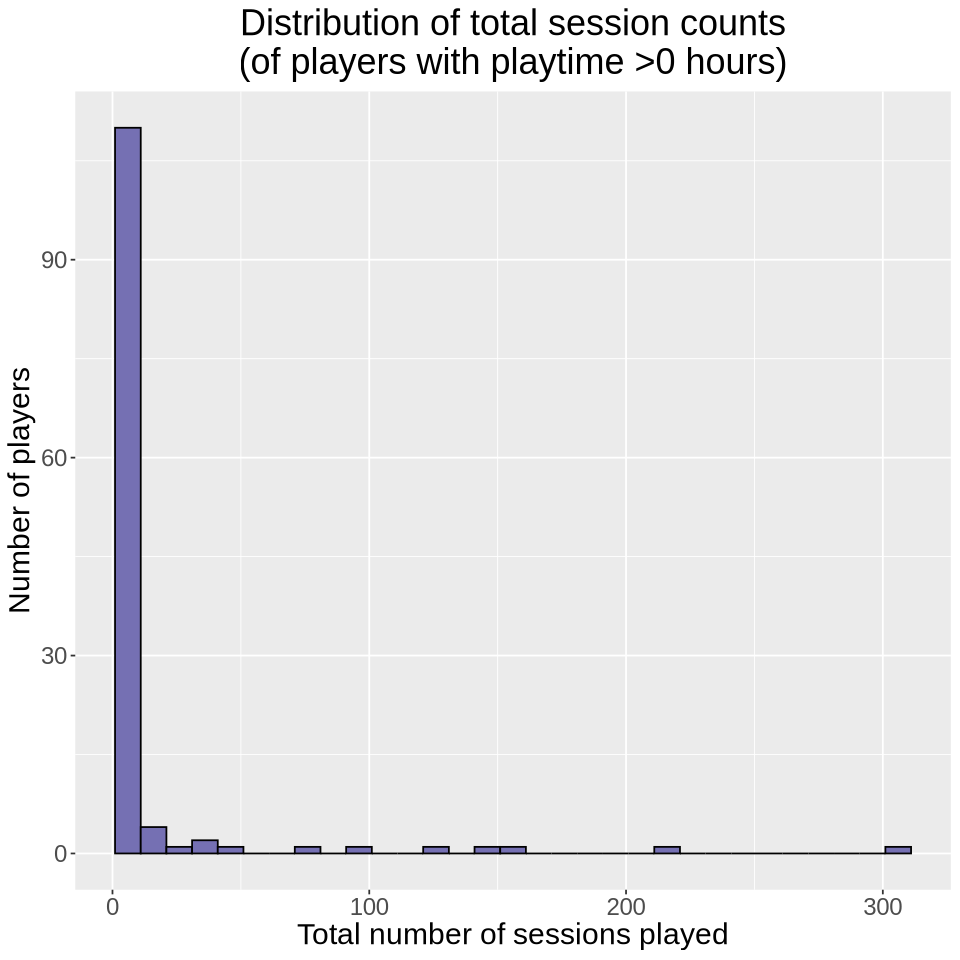

In [5]:
sessions_unique_hash <- sessions |>
    group_by(hashedEmail) |>
    summarize(num_sessions = n()) |>
    arrange(desc(num_sessions))
sessions_unique_hash

options(repr.plot.width = 8, repr.plot.height = 8)
sessions_count <- sessions_unique_hash |>
    ggplot(aes(num_sessions)) +
        geom_histogram(colour = "black", fill = "#7570b3ff", binwidth = 10, boundary = 1) +
        labs(x = "Total number of sessions played", y = "Number of players",
             title = "Distribution of total session counts\n(of players with playtime >0 hours)") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))
sessions_count

***Graph 1*** Derived from `sessions.csv` by counting each unique `hashedEmail`'s number of observations in the dataset. One observation marks one gaming session, i.e. one instance of a player’s uninterrupted Minecraft session on PLAICraft.ai, so we can count how many sessions each player has played (for players with more than 0 hours of playtime). This graph shows a distribution of the total counts of players' sessions.

As we can see, one may argue from the distribution of total session counts that players who logged in more often played the game more and therefore have higher data contribution. However, the average duration of each player's sessions varies. Some play for 67 minutes per session on average, while others only play for 15 minutes (see code below, `mean_sesh_duration` vs. `num_sessions`
). Therefore, session count is not a good metric for player data contribution. `played_hours` from `players.csv` is sufficient to represent players' data contribution.

In [6]:
sessions_duration <- sessions |>
    mutate(time_diff = end_time - start_time) |>
    group_by(hashedEmail) |>
    summarize(mean_sesh_duration = mean(time_diff),
              median_sesh_duration = median(time_diff)) |>
    merge(sessions_unique_hash) |>
    arrange(desc(num_sessions))
head(sessions_duration, n = 6)
tail(sessions_duration, n = 6)

,hashedEmail,mean_sesh_duration,median_sesh_duration,num_sessions
,<chr>,<drtn>,<drtn>,<int>
1,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15.46774 mins,7 mins,310
2,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,66.99087 mins,63 mins,219
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,62.55975 mins,49 mins,159
4,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,80.45578 mins,62 mins,147
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,29.79231 mins,22 mins,130
6,b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,150.34043 mins,143 mins,94


,hashedEmail,mean_sesh_duration,median_sesh_duration,num_sessions
,<chr>,<drtn>,<drtn>,<int>
120,f707d141be44b2bf963eb171dbd14599059b4dda09aa002ba95ead4fa67273a7,8 mins,8 mins,1
121,f7875ae87a61632030d5c4029ee8cf081be7047b2b4a9c04ab5a706f59786197,19 mins,19 mins,1
122,fc0224c81384770e93ca717f32713960144bf0b52ff67639433a5c06a653a882,16 mins,16 mins,1
123,fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,80 mins,80 mins,1
124,fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,9 mins,9 mins,1
125,fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,72 mins,72 mins,1


## <u>Exploratory data analysis (no additional wrangling)</u>
In this section, we will look at the relationships between `played_hours` and our possible choices of predictor variables, `experience`, `subscribe`, `gender`, and `Age` individually.

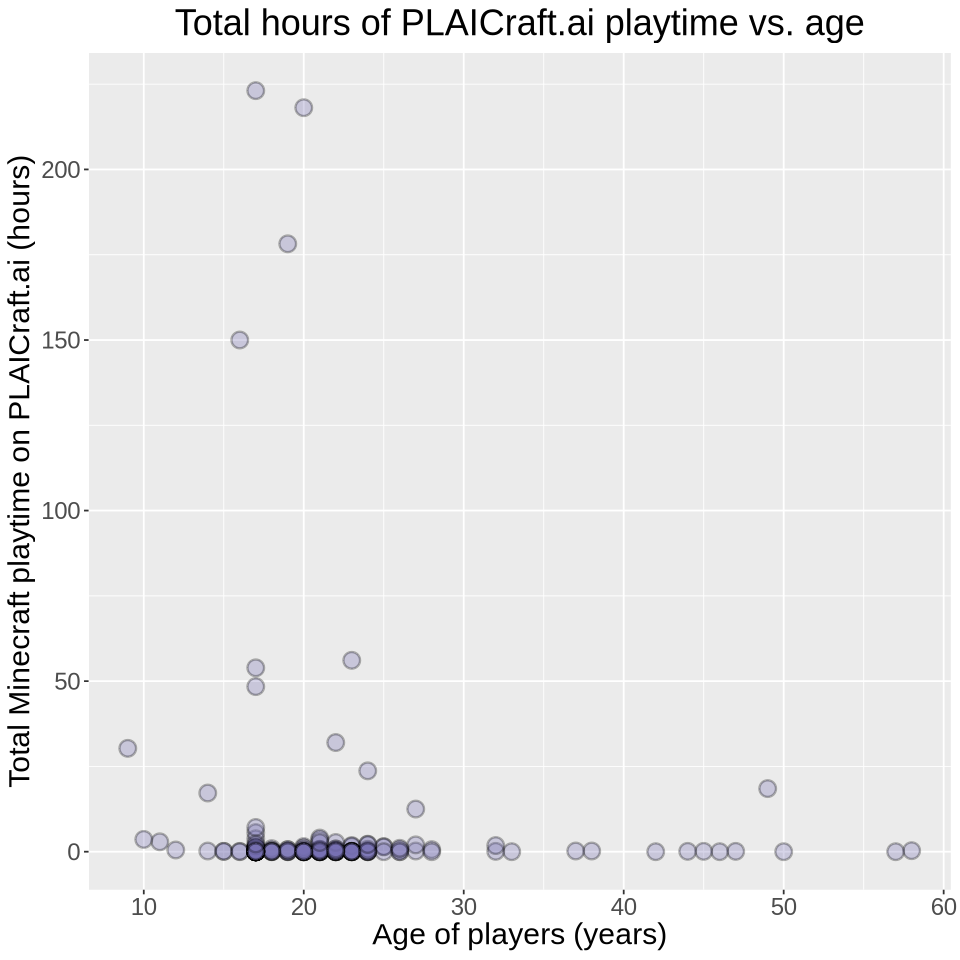

In [7]:
options(repr.plot.width = 8, repr.plot.height = 8)
hour_v_age <- players |>
    na.omit() |> # Removing 2 NA's (2 observations).
    ggplot(aes(x = Age, y = played_hours)) +
        geom_point(alpha = 0.3, size = 4, stroke = 1, shape = 21, fill = "#7570b3ff") +
        labs(x = "Age of players (years)", y = "Total Minecraft playtime on PLAICraft.ai (hours)",
             title = "Total hours of PLAICraft.ai playtime vs. age") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))

# Ended up not including this graph because I don't think it's useful.
hour_v_age_log <- players |>
    na.omit() |>
    filter(played_hours > 0) |> # Because we're logging it.
    ggplot(aes(x = Age, y = played_hours, fill = gender)) +
        geom_point(alpha = 0.3, size = 4, stroke = 1, shape = 21) +
        labs(x = "Age of players (years)", y = "Log total Minecraft playtime hours on PLAICraft.ai (Log10)",
             fill = "Self-identified gender of player",
             title = "Log total hours of PLAICraft.ai playtime vs. age\n(for players with > 0 hours)") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = "Dark2") +
        scale_colour_brewer(palette = "Dark2") +
        scale_y_log10()

hour_v_age

***Graph 2*** From `players` data, `played_hours` vs. `Age`, coloured by `gender`.

Looking at Graph 2, `Age` and `played_hours` do not appear to have a strong linear relationship. One can argue that there is a weak negative relationship between the two, where total playtime hours decrease as age increases. However, this supposed trend could simply be a consequence of the younger ages (around 15 to 25 years) having more registered participants and therefore more variability in their `played_hours` than the older ages. In fact, most participants in all age ranges similarly have `played_hours` of around 0 hours. Therefore, we assert that there is *no linear relationship* between `played_hours` and `Age`.

From visualization alone, it is difficult to ascertain if age would be a good predictor for `played_hours`. While a predictive model could likely estimate the total playtime of players above 25 with more consistency, the high variability in playtime hours for players between 15 and 25 may worsen the model's performance. If `Age` were to be used as a predictor variable, it would likely need to be used with at least another predictor variable.

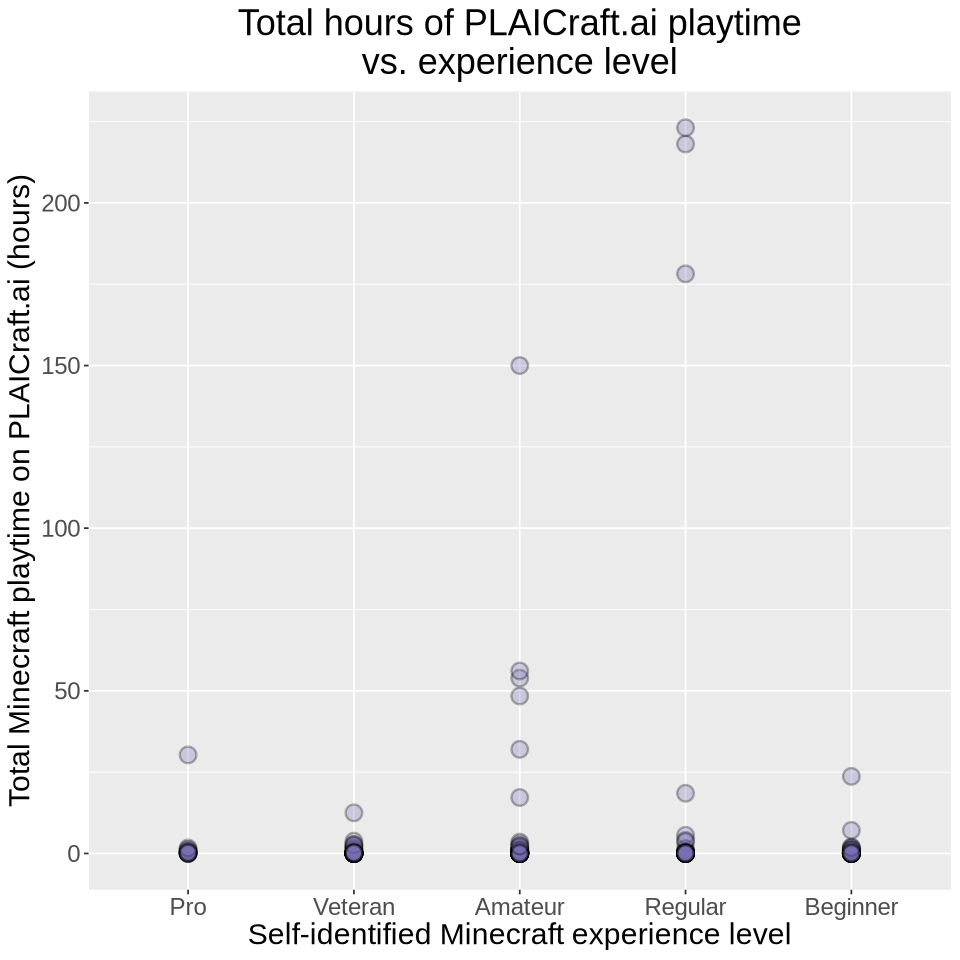

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)
hour_v_exp <- players |>
    ggplot(aes(x = experience, y = played_hours)) +
        geom_point(alpha = 0.3, size = 4, stroke = 1, shape = 21, fill = "#7570b3ff") +
        labs(x = "Self-identified Minecraft experience level", y = "Total Minecraft playtime on PLAICraft.ai (hours)",
             title = "Total hours of PLAICraft.ai playtime\nvs. experience level") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))
hour_v_exp

***Graph 3*** From `players` data, a categorical scatter plot of the `played_hours` of all players, categorized by self-identified experience level (`experience`).

Looking at Graph 3, `experience` may potentially be a decent predictor for `played_hours`. Most self-identified Pro, Veteran, and Beginner players have low playtimes hovering around 0 hours, with one or two "outlier" participants who play more hours. A regression prediction model would likely be able to estimate the `played_hours` of players from these experience levels with good accuracy. Amateur and Regular players have more individuals with higher playtimes, though the majority still remain around 0 hours. There is higher variability and range in `played_hours` for these experience levels, which may make them more difficult to predict. Like `Age`, it is difficult to decide if `experience` would be a good predictor from visualization alone.

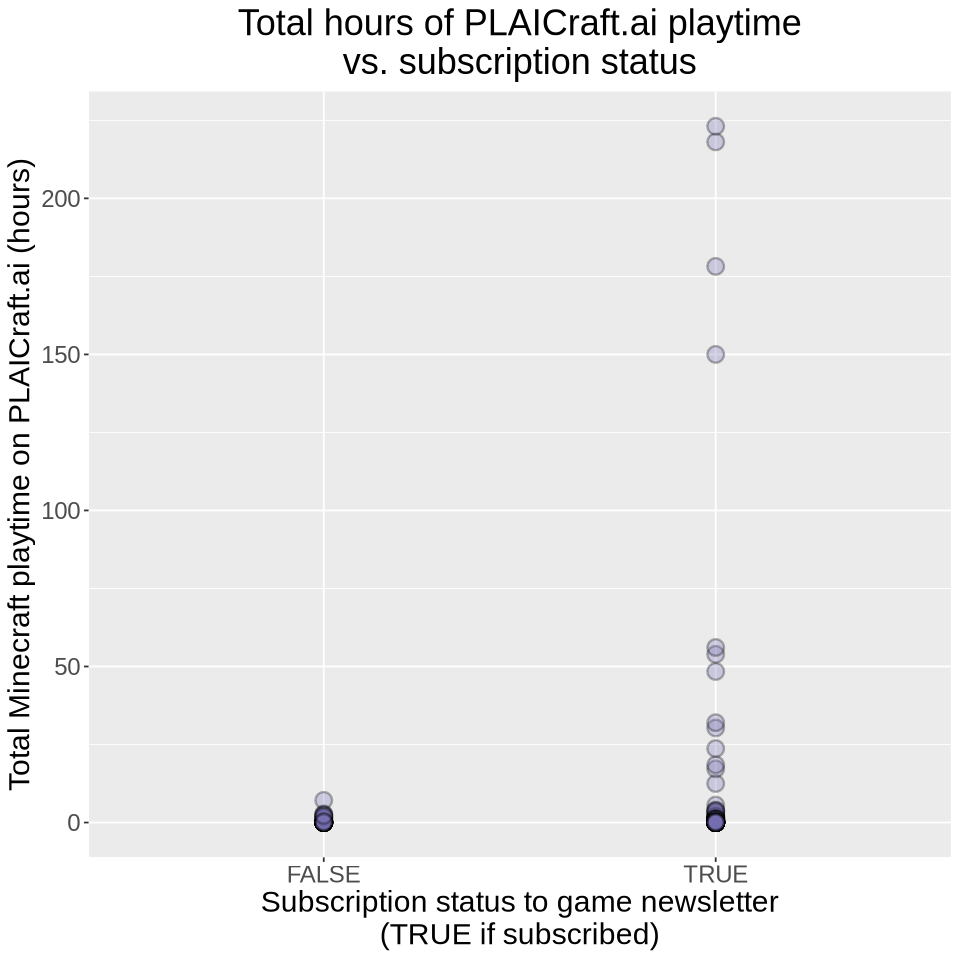

In [9]:
hour_v_sub <- players |>
    ggplot(aes(x = subscribe, y = played_hours)) +
        geom_point(alpha = 0.3, size = 4, stroke = 1, shape = 21, fill = "#7570b3ff") +
        labs(x = "Subscription status to game newsletter\n(TRUE if subscribed)",
             y = "Total Minecraft playtime on PLAICraft.ai (hours)",
             title = "Total hours of PLAICraft.ai playtime\nvs. subscription status") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))
hour_v_sub

***Graph 4*** From `players` data, a categorical scatter plot of the `played_hours` of all players, categorized by subscription status (`subscribe`). `TRUE` indicates that the player is subscribed to the game-related newsletter (presumably provided by the researchers), and `FALSE` indicates otherwise.

It appears that `subscribe` may be a reasonable predictor for `played_hours` (Graph 4), as all players who are not subscribed to the newsletter (`FALSE` category) have `played_hours` below 12.5 hours. The great variability and range in the playtimes of players who are subscribed may make prediction difficult, but this problem may be alleviated by including another predictor variable. The `subscribe` variable is useful in that every player who is not subscribed can reliably be predicted as having low playtime. As for players who are subscribed, the predictions would have to rely on at least another predictor variable.

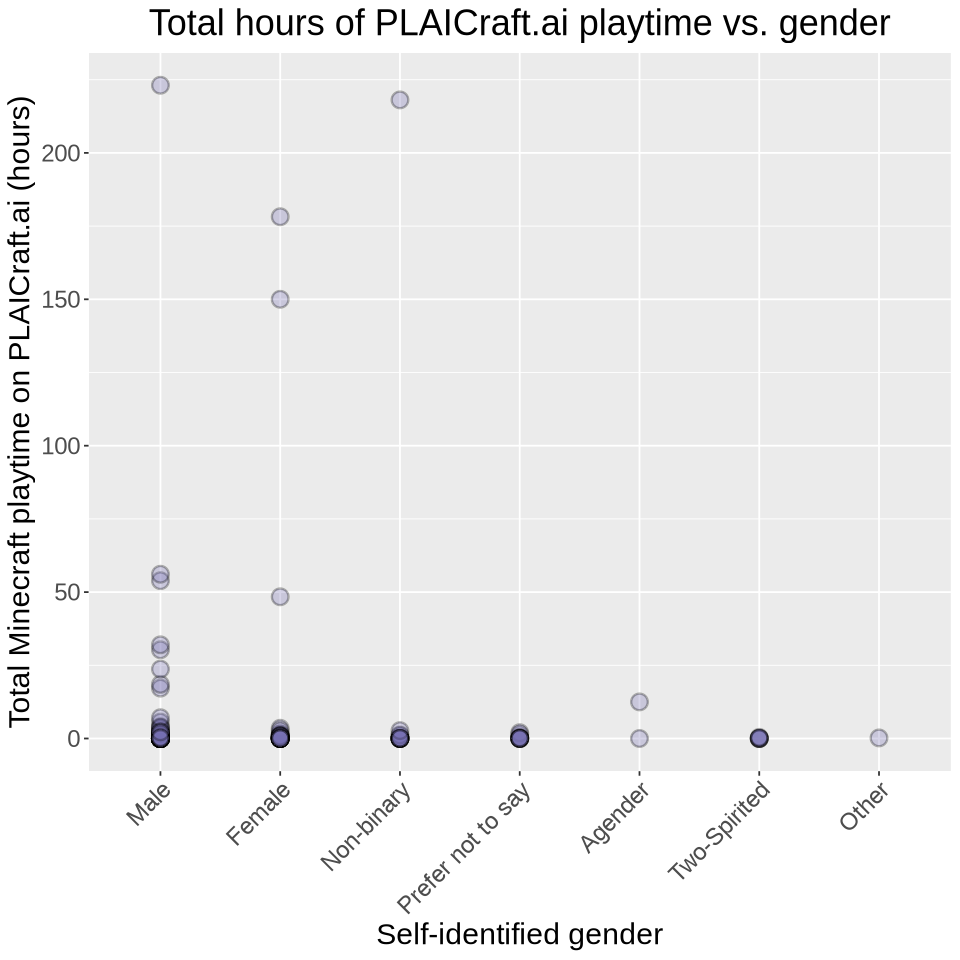

In [10]:
hour_v_gender <- players |>
        ggplot(aes(x = gender, y = played_hours)) +
        geom_point(alpha = 0.3, size = 4, stroke = 1, shape = 21, fill = "#7570b3ff") +
        labs(x = "Self-identified gender", y = "Total Minecraft playtime on PLAICraft.ai (hours)",
             title = "Total hours of PLAICraft.ai playtime vs. gender") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5),
              axis.text.x = element_text(angle = 45, hjust = 1))
hour_v_gender

***Graph 5*** From `players` data, a categorical scatter plot of the `played_hours` of all players, categorized by self-identified `gender`.

Like some of the previous scatter plots, it is difficult to decide if `gender` is an optimal predictor for `played_hours` or not. All the genders other than Male appear to mostly have low playtimes (around 0 hours) except for a few "outliers" with higher hours in Female, Non-binary, and Agender players. A prediction model would likely estimate the hours of these outliers to be around 0, even though these are the individuals that the researchers should be looking for. As for Male players, there are more than a few players with `played_hours` of around 10 to 25 hours, but most still only have around 0 hours, similar to the other genders. If `gender` were to be used as a predictor for `played_hours`, it would likely not be used alone.

Through our visualizations (Graphs 2-5) exploring the individual relationships between our response variable (`played_hours`) and our potential predictor variables (`experience`, `subscribe`, `gender`, and `Age`), we cannot decide which predictor variables or which combination of predictor variables to choose. Therefore, we decided to rely on best subset selection.

## <u>Methods and results</u>

Initially, we asked if we could predict a player's data contribution (`played_hours`) using a ***selection*** of the player's characteristics (`experience`, `subscribe`, `gender`, `Age`). To refine our research question, we used **best subset selection** to compute the most suitable combination of the player's characteristics as predictor variables for our response variable `played_hours`. Not every player characteristic may be suitable for predicting the number of played hours, and including them could worsen the performance of the predictive model.

We decided to use K-nearest neighbours (KNN) regression for our predictive analysis. Three of our potential predictor variables (`experience`, `subscribe`, and `gender`) are categorical variables. The remaining `Age` does not appear to have a linear relationship with `played_hours` (Graph 2). We are using non-linear predictive variables to estimate a numerical response variable, making KNN regression the optimal predictive algorithm.

We first removed the columns we don't need (`hashedEmail`, `name`) in `players` and omitted observations with `NA`. Then, we split `players` data into 75% training and 25% testing.

In [11]:
set.seed(42) # NOBODY TOUCH THIS PLEASE.

# I decided to use best subset selection over forward selection because we don't have that many potential predictor variables
# anyway (only 4). Since we don't have any computational costs or limits for using best subset selection, there's no reason not to,
# especially when forward selection is not as comprehensive.

# For convenience, columns we don't need for analysis are removed.
players_removed <- players |>
    select(-hashedEmail, -name) |>
    na.omit()

# Splitting the data.
players_split <- initial_split(players_removed, prop = 0.75, strata = played_hours) # Standard 75/25 split for training/testing.
players_training <- training(players_split)
players_testing <- testing(players_split)

### <u>Pre-processing</u>
Next, using the training data, we performed 10-fold cross-validation on all 15 candidate models made from the 15 possible combinations (subsets) of predictor variables. To make the categorical predictor variables (`experience`, `subscribe`, `gender`) usable in the KNN regression model, we converted them into dummy variables using the pre-processing steps in our `tidymodels` recipe (`step_dummy()`). As KNN regression uses numerical straight-line distances to make predictions, it cannot directly handle text-based categories. `subscribe` was converted from logical to factor (Table 1) for this very purpose, as `step_dummy()` can only process factors. Unlike `subscribe` and `gender`, `experience` is an ordinal categorical variable. However, we decided against converting it to numbers like 1 to 5 because doing so assumes that the difference between each category (e.g. beginner vs. amateur, amateur vs. regular) is the same.

As the converted dummy variables only consist of 0s and 1s, we had to standardize them using `step_scale()` and `step_center()` in our recipe when `Age` is included as a predictor variable. As mentioned, KNN algorithms rely on Euclidean distances to make predictions and do not have any sense of scale. Without standardization, the dummy variables would become uninformative as the algorithm would only rely on `Age`, the variable with the larger values, to calculate distances and make predictions.

We chose 10-fold over 5-fold cross-validation because 10-fold CV generally yields more reliable predictions. As 10-fold CV uses 90% of the training set as training data per iteration, it is more representative of the entire training set (and dataset) than 5-fold CV.

Finally, we used a grid of numbers of neighbours $K$ ranging from 1 to 10, tuned all 15 candidate models, and returned for each model (1) the lowest RMSPE and (2) the $K$ that gave the lowest RMSPE.

In [12]:
# knn tuning model that will be used for every candidate model.
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

In [13]:
# A separate code cell for all the recipes.
# Recipes for each possible combination of predictor variables (15 total). Our response variable is played_hours.

# 1 predictor
# Recipe 1: experience
recipe_1 <- recipe(played_hours ~ experience, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |> # Scale and center are not necessary when there's only 1 predictor.
    step_center(all_predictors())   # They're there because I copy-pasted the recipes. :D
# Recipe 2: subscribe
recipe_2 <- recipe(played_hours ~ subscribe, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 3: gender
recipe_3 <- recipe(played_hours ~ gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 4: Age
recipe_4 <- recipe(played_hours ~ Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 2 predictors
# Recipe 5: experience + subscribe
recipe_5 <- recipe(played_hours ~ experience + subscribe, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 6: experience + gender
recipe_6 <- recipe(played_hours ~ experience + gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 7: experience + Age
recipe_7 <- recipe(played_hours ~ experience + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 8: subscribe + gender
recipe_8 <- recipe(played_hours ~ subscribe + gender, data = players_training) |>
    step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 9: subscribe + Age
recipe_9 <- recipe(played_hours ~ subscribe + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 10: gender + Age
recipe_10 <- recipe(played_hours ~ gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 3 predictors
# Recipe 11: experience + subscribe + gender
recipe_11 <- recipe(played_hours ~ experience + subscribe + gender, data = players_training) |>
     step_dummy(all_predictors()) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 12: experience + subscribe + Age
recipe_12 <- recipe(played_hours ~ experience + subscribe + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 13: experience + gender + Age
recipe_13 <- recipe(played_hours ~ experience + gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
# Recipe 14: subscribe + gender + Age
recipe_14 <- recipe(played_hours ~ subscribe + gender + Age, data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 4 predictors
# Recipe 15: ALL 4 variables, experience + subscribe + gender + Age
recipe_15 <- recipe(played_hours ~ ., data = players_training) |>
    step_dummy(all_predictors(), -Age) |>
    step_zv(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# I tried to make a recipe_printer, but it was impossible so we're stuck with this tedious code. :(

In [14]:
set.seed(84) # NOBODY TOUCH THIS PLEASE.

# Running 10-fold cross-validation for all candidate models.
vfold <- vfold_cv(players_training, v = 10, strata = played_hours)

# Range of k values.
kvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# A convenient function that spits out the best k and lowest rmspe (mean) of any candidate model (recipe).
workflow_printer <- function(recipe, model) {
    workflow() |>
    add_recipe(recipe) |>
    add_model(model) |>
    tune_grid(resamples = vfold, grid = kvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)
}

workflow_1 <- workflow_printer(recipe_1, knn_tune)
workflow_2 <- workflow_printer(recipe_2, knn_tune)
workflow_3 <- workflow_printer(recipe_3, knn_tune)
workflow_4 <- workflow_printer(recipe_4, knn_tune)
workflow_5 <- workflow_printer(recipe_5, knn_tune)
workflow_6 <- workflow_printer(recipe_6, knn_tune)
workflow_7 <- workflow_printer(recipe_7, knn_tune)
workflow_8 <- workflow_printer(recipe_8, knn_tune)
workflow_9 <- workflow_printer(recipe_9, knn_tune)
workflow_10 <- workflow_printer(recipe_10, knn_tune)
workflow_11 <- workflow_printer(recipe_11, knn_tune)
workflow_12 <- workflow_printer(recipe_12, knn_tune)
workflow_13 <- workflow_printer(recipe_13, knn_tune)
workflow_14 <- workflow_printer(recipe_14, knn_tune)
workflow_15 <- workflow_printer(recipe_15, knn_tune)

# Combining each candidate model's best k and lowest rmspe for comparison.
best_subset <- rbind(workflow_1, workflow_2, workflow_3, workflow_4, workflow_5,
                     workflow_6, workflow_7, workflow_8, workflow_9, workflow_10,
                     workflow_11, workflow_12, workflow_13, workflow_14, workflow_15) |>
    mutate(recipe_workflow_n = c(1:15)) |>
    arrange(mean)

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x3

There were issues with some computations   A: x10



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x2



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a 

We compared the lowest RMSPE values from each of the 15 candidate models' individual 10-fold cross-validations and chose the model with the lowest overall RMSPE.

In [15]:
head(best_subset, n = 6)

neighbors,.metric,.estimator,mean,n,std_err,.config,recipe_workflow_n
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
10,rmse,standard,23.46515,10,7.282559,Preprocessor1_Model10,5
1,rmse,standard,23.91264,10,7.579489,Preprocessor1_Model01,2
1,rmse,standard,23.91396,10,7.581235,Preprocessor1_Model01,3
1,rmse,standard,23.91665,10,7.579021,Preprocessor1_Model01,1
1,rmse,standard,23.92039,10,7.581346,Preprocessor1_Model01,8
10,rmse,standard,25.09563,10,7.120350,Preprocessor1_Model10,9


From our pre-processing 10-fold cross-validation with the 15 candidate models, we see that the model using `experience` and `subscribe` (`recipe_5` / `workflow_5`) with $K$ = 10 has the lowest RMSPE ***overall*** (23.47) compared to the individual lowest RMSPEs of the other candidate models. From this, we derived our **specific research question** stated in the beginning:
#### Can we predict a player's data contribution (`played_hours`) using the player's Minecraft experience level (`experience`) and subscription status to game-related newsletter (`subscribe`) from the dataset `players.csv`?

### <u>Evaluating on the testing data</u>
We evaluated our finalized KNN regression model on the testing set. We first re-trained our model on the entire training set (75% of `players.csv`).

In [16]:
# Building the "official" knn regression model using recipe 5 and k = 10.
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("regression")

# Training the model using the entirety of the training set.
players_knn_fit <- workflow() |>
    add_recipe(recipe_5) |>
    add_model(knn_spec_final) |>
    fit(data = players_training)

Then, we used the fully trained model to predict `played_hours` in the testing set (25% of `players.csv`). We've withheld the testing data from our pre-processing and training steps to allow us to evaluate the performance of our model without bias. Unfortunately, we cannot visualize our predictive analysis because (1) we have 2 predictors, so we would need a 3D space to visualize them against the response variable, and (2) the predictor variables are categorical. We cannot assess if our model is over- or underfitting the data.

In [17]:
# Using the fully trained model on the testing set.
players_pred <- players_knn_fit |>
    predict(players_testing) |>
    bind_cols(players_testing)
players_pred

# Extracting the RMSPE from using our model on the testing set.
players_knn_rmspe <- players_pred |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse")
players_knn_rmspe

.pred,experience,subscribe,played_hours,gender,Age
<dbl>,<fct>,<fct>,<dbl>,<fct>,<int>
0.72,Veteran,FALSE,0.0,Male,17
0.03,Amateur,TRUE,0.7,Female,21
0.03,Veteran,TRUE,0.0,Female,22
⋮,⋮,⋮,⋮,⋮,⋮
0.31,Pro,FALSE,0.2,Male,17
0.46,Amateur,FALSE,0.0,Male,17
0.72,Veteran,FALSE,0.3,Male,22


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,12.22768


## <u>Discussion</u>

Our final model's RMSPE from predicting the testing set is 12.23 (the code cell above), which is a significant improvement from 23.47, the RMSPE of our tuned model during cross-validation (the code cell below).

In [18]:
head(best_subset, n = 1) # From the model tuning.

neighbors,.metric,.estimator,mean,n,std_err,.config,recipe_workflow_n
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
10,rmse,standard,23.46515,10,7.282559,Preprocessor1_Model10,5


This significant improvement in prediction accuracy between the tuned model and the finalized model (which trained on 75% of the dataset) can mean that our model is able to generalize unknown data pretty well.

However, this large difference in RMSPE can indicate that our model's prediction ability is inconsistent. With how the data was randomly assigned to the training set or the validation/testing set, the data assigned to the final testing set could've just been really "lucky", allowing our model to fit the data really well by chance.

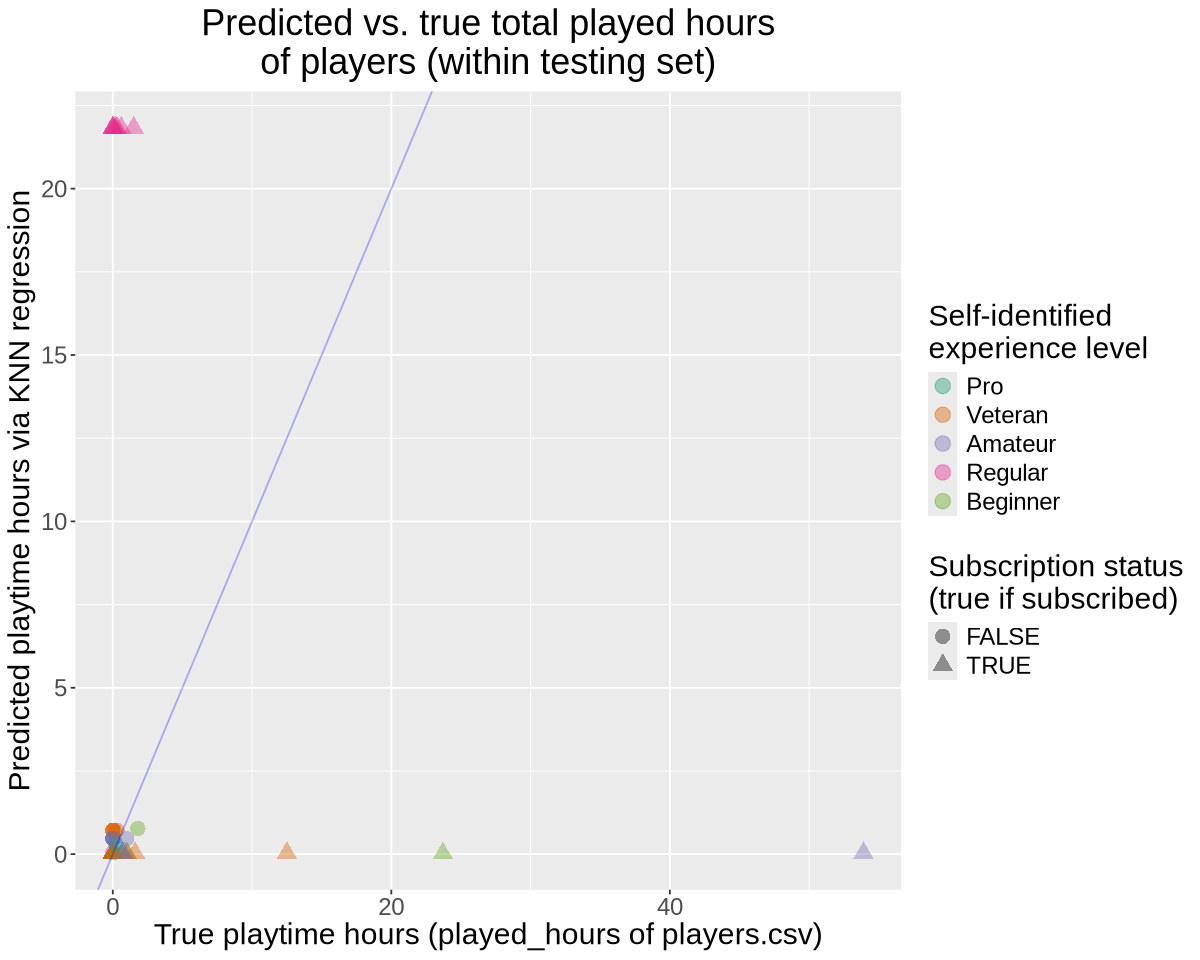

In [19]:
options(repr.plot.width = 10, repr.plot.height = 8)

pred_vs_true <- players_pred |>
    ggplot(aes(x = played_hours, y = .pred, colour = experience, shape = subscribe)) +
        geom_point(alpha = 0.4, size = 4) +
        labs(x = "True playtime hours (played_hours of players.csv)", y = "Predicted playtime hours via KNN regression",
             title = "Predicted vs. true total played hours\nof players (within testing set)",
             colour = "Self-identified\nexperience level", shape = "Subscription status\n(true if subscribed)") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_colour_brewer(palette = "Dark2") +
        geom_abline(slope = 1, intercept = 0, colour = "blue", alpha = 0.3)
pred_vs_true

***Graph 6*** From `players_pred`, the prediction results of our finalized KNN regression model on the testing set (25% of `players.csv`). Predicted `played_hours` is plotted against actual `played_hours`, with experience level indicated by colour and subscription status indicated by shape. <mark>**The blue line is not the best-fit line; it is $y = x$. Any prediction value that equals the actual value would fall on this line.**</mark>

Our model could be deceptively accurate (low RMSPE) because most players within `players.csv` have very low playtimes (median playtime is 0.1 hours, see Table 2). As we can see in Graph 6, there is a player with over 50 hours of true playtime predicted by the model to have around 0 hours. On the other hand, there are multiple players with around 0 hours of true playtime predicted to have over 20 hours. Incidentally, all of these players have Regular experience level.

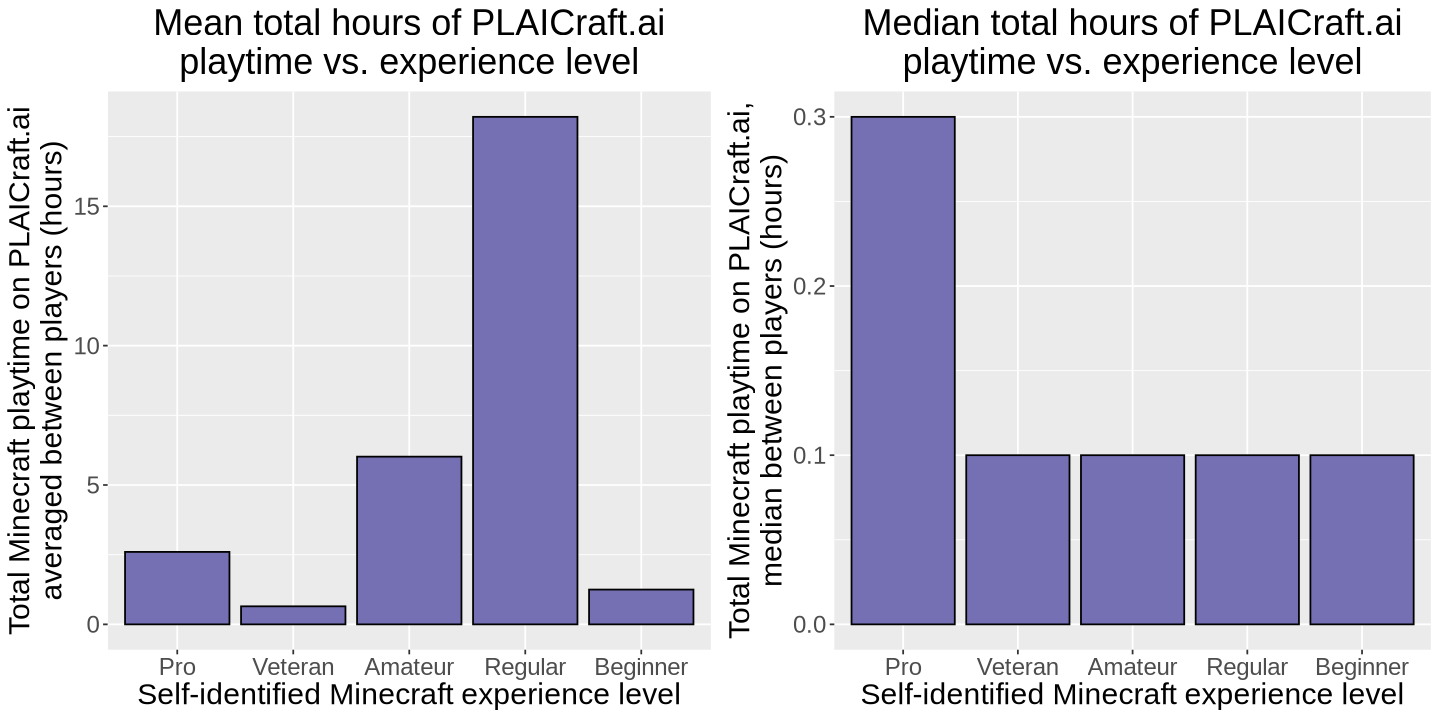

In [20]:
hour_v_exp_mean <- players |>
    group_by(experience) |>
    summarize(played_hours = mean(played_hours)) |>
    ggplot(aes(x = experience, y = played_hours)) +
        geom_bar(stat = "identity", colour = "black", fill = "#7570b3ff") +
        labs(x = "Self-identified Minecraft experience level",
             y = "Total Minecraft playtime on PLAICraft.ai\naveraged between players (hours)",
             title = "Mean total hours of PLAICraft.ai\nplaytime vs. experience level") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_colour_brewer(palette = "Dark2")

hour_v_exp_med <- players |>
    group_by(experience) |>
    summarize(played_hours = median(played_hours)) |>
    ggplot(aes(x = experience, y = played_hours)) +
        geom_bar(stat = "identity", colour = "black", fill = "#7570b3ff") +
        labs(x = "Self-identified Minecraft experience level",
             y = "Total Minecraft playtime on PLAICraft.ai,\nmedian between players (hours)",
             title = "Median total hours of PLAICraft.ai\nplaytime vs. experience level") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_colour_brewer(palette = "Dark2")

options(repr.plot.width = 12, repr.plot.height = 6)
grid.arrange(hour_v_exp_mean, hour_v_exp_med, ncol = 2)

***Graph 7*** From `players.csv`, side-by-side comparison of the mean and median `played_hours` of all players, categorized by experience level.

We see that the high average playtime for players with Regular experience is skewed by a few players, as the median is only 0.1 hours (Graph 7, see also Graph 8). It is very likely that our training set included all the Regular players with high `played_hours`, so when the model was used on the testing set, it incorrectly predicted all players with Regular experience to have higher `played_hours` (Graph 6).

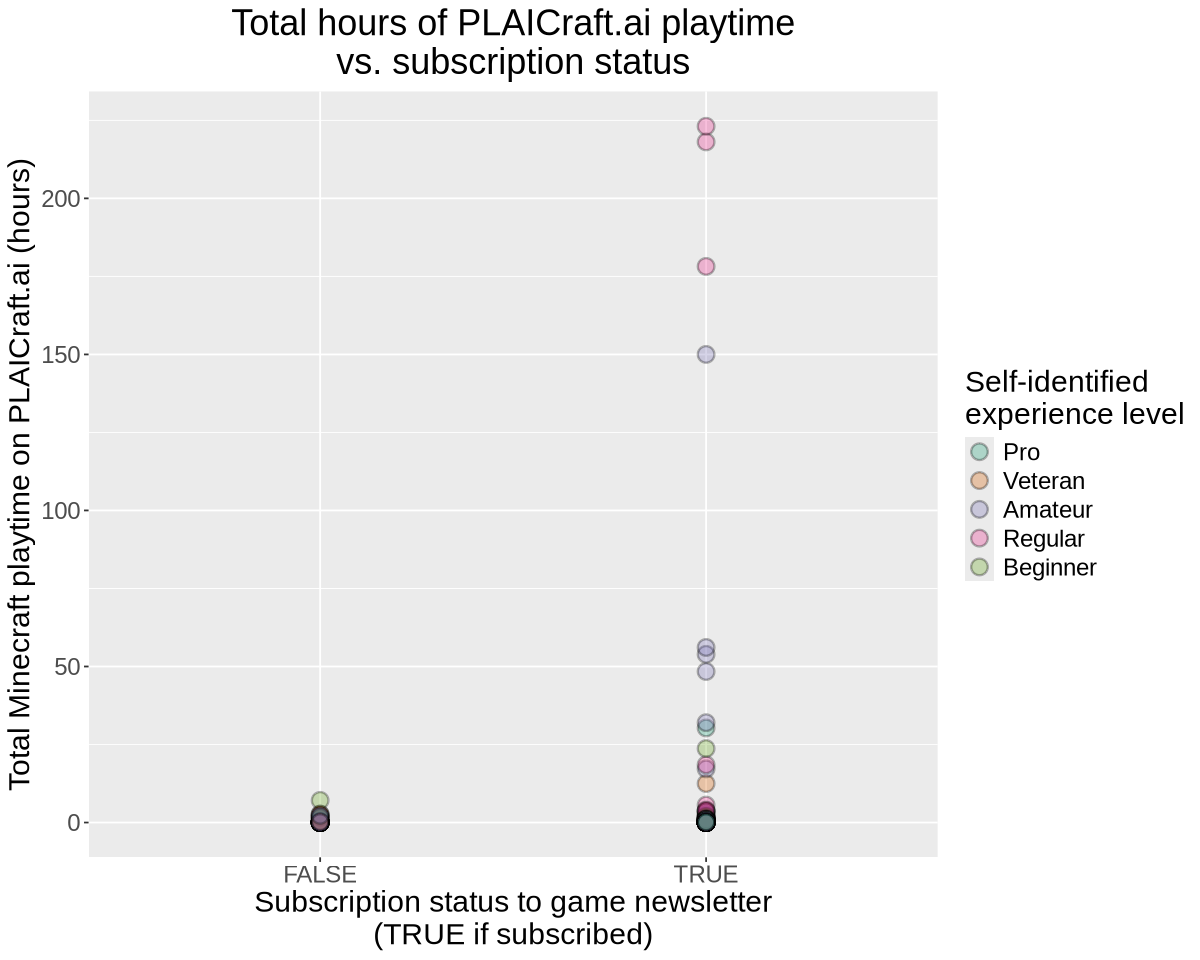

In [21]:
options(repr.plot.width = 10, repr.plot.height = 8)
hour_v_sub_exp <- players |>
    ggplot(aes(x = subscribe, y = played_hours, fill = experience)) +
        geom_point(alpha = 0.3, size = 4, stroke = 1, shape = 21) +
        labs(x = "Subscription status to game newsletter\n(TRUE if subscribed)",
             y = "Total Minecraft playtime on PLAICraft.ai (hours)",
             title = "Total hours of PLAICraft.ai playtime\nvs. subscription status",
             fill = "Self-identified\nexperience level") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = "Dark2") +
        scale_colour_brewer(palette = "Dark2")
hour_v_sub_exp

***Graph 8*** The same graph as Graph 4, coloured by `experience`.

Our model does a good job when predicting players with no newsletter subscription, as they all have low playtime hours (Graph 6, Graph 8). As expected, it is more difficult to predict the `played_hours` of players who are subscribed using `experience`, as it is only a few Amateur and Regular individuals who have significantly higher playtime hours out of the majority of Amateur and Regular participants. Overall, the consistency and performance of our KNN regression model can be further improved if there are more observations in `players.csv`.

It was surprising that our finalized model performed significantly better on the final testing set compared to how the tuned model performed on the validation set during cross-validation. We expected to see a final RMSPE that was either higher or similar to the RMSPE from cross-validation. Ultimately, it appears that there is no optimal combination of experience, gender, and age that could determine if a player would play many hours (contribute a lot of data) or not. Usually, it's only a small number of individuals from certain categories in these variables who play a lot, and these individuals are basically the "outliers" of their groups/categories, as most individuals within those categories do not play a lot, if at all. Among the few players who do play a lot, there could be a unique common characteristic that they share, but we simply do not have that information.

Whether a player subscribes or not to the newsletter is not a personal characteristic like (self-proclaimed) experience level, gender, or age. The research team therefore cannot focus their recruitment efforts towards "players who are subscribed" or "players who are more likely to subscribe" because the subscription presumably only comes during or after registration to PLAICraft.ai. While we have no information regarding the contents of this game-related newsletter, we assume that it is procured by the research group (similar to when you register an account for any site, there is often a question asking if you would like to receive newsletter updates). Players who have committed to playing on PLAICraft.ai may be more inclined to subscribe, so they can receive updates from the research group.

To increase the chances of recruiting players who will contribute a lot of data, the research group should continue to keep a low barrier to entry for PLAICraft.ai, as the majority of the few players who contributed the most data were Amateur and Regular players. If the research group really wants to determine the common characteristics shared by players who play a lot, they should collect more data on them to determine what sets them apart from players or just registrants who don't contribute a lot of data. A possible explanation as to why the median playtime is 0.1 hours is that many players signed up, played a bit, and then lost interest, because why should players choose to play on PLAICraft.ai over their personal Minecraft servers? More experienced players who have cleared the default survival mode before are probably more interested in modded gameplay or special game modes like Hypixel. Perhaps the researchers should switch up their recruitment tactics and invite people to play on PLAICraft.ai with their friends, or they should overhaul their survival Minecraft server entirely and set some sort of server-wide goal (e.g. in the case of civilization-simulating Minecraft servers, the goal is to expand your territory). Such an incentive or common goal among players could make the server more appealing.

As the research team has included a built-in voice-chat feature with their Minecraft server on PLAICraft.ai (see their blog), building off of our research question, we can ask some interesting future questions regarding player interactions. For example, do (self-determined) Beginner and Amateur players play more hours when there is another more experienced player guiding them? How do the playtime hours compare between players who prefer to play in a group vs. players who play alone? Do many players change their subscription status before or after having played any hours?